In [1]:
from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/csv


In [3]:
from abupy import AbuPickStockBase, ps, ABuRegUtil, tl
from __future__ import absolute_import

class AbuPickRegressAngMinMax(AbuPickStockBase):
    """拟合角度选股因子示例类"""
    def _init_self(self, **kwargs):
        """通过kwargs设置拟合角度边际条件，配置因子参数"""

        # 暂时与base保持一致不使用kwargs.pop('a', default)方式
        # fit_pick中 ang > threshold_ang_min, 默认负无穷，即默认所有都符合
        self.threshold_ang_min = -np.inf
        if 'threshold_ang_min' in kwargs:
            # 设置最小角度阀值
            self.threshold_ang_min = kwargs['threshold_ang_min']

        # fit_pick中 ang < threshold_ang_max, 默认正无穷，即默认所有都符合
        self.threshold_ang_max = np.inf
        if 'threshold_ang_max' in kwargs:
            # 设置最大角度阀值
            self.threshold_ang_max = kwargs['threshold_ang_max']

    @ps.reversed_result
    def fit_pick(self, kl_pd, target_symbol):
        """开始根据自定义拟合角度边际参数进行选股"""
        # 计算走势角度
        ang = ABuRegUtil.calc_regress_deg(kl_pd.close, show=False)
        # 根据参数进行角度条件判断
        if self.threshold_ang_min < ang < self.threshold_ang_max:
            return True
        return False
    
    def fit_first_choice(self, pick_worker, choice_symbols, *args, **kwargs):
        raise NotImplementedError('AbuPickRegressAng fit_first_choice unsupported now!')

In [5]:
class AbuPickStockShiftDistance(AbuPickStockBase):
    """位移路程比选股因子示例类"""

    def _init_self(self, **kwargs):
        """通过kwargs设置位移路程比选股条件，配置因子参数"""
        self.threshold_sd = kwargs.pop('threshold_sd', 2.0)
        self.threshold_max_cnt = kwargs.pop('threshold_max_cnt', 4)
        self.threshold_min_cnt = kwargs.pop('threshold_min_cnt', 1)

    @ps.reversed_result
    def fit_pick(self, kl_pd, target_symbol):
        """开始根据位移路程比边际参数进行选股"""

        pick_line = tl.AbuTLine(kl_pd.close, 'shift distance')
        shift_distance = pick_line.show_shift_distance(step_x=1.2, show_log=False, show=False)
        shift_distance = np.array(shift_distance)
        # show_shift_distance返回的参数为四组数据，最后一组是每个时间段的位移路程比值
        sd_arr = shift_distance[:, -1]
        # 大于阀值的进行累加和计算
        # noinspection PyUnresolvedReferences
        threshold_cnt = (sd_arr >= self.threshold_sd).sum()
        # 边际条件参数开始生效
        if self.threshold_max_cnt > threshold_cnt >= self.threshold_min_cnt:
            return True
        return False

    def fit_first_choice(self, pick_worker, choice_symbols, *args, **kwargs):
        raise NotImplementedError('AbuPickStockShiftDistance fit_first_choice unsupported now!')

In [7]:
class AbuPickStockNTop(AbuPickStockBase):
    """根据一段时间内的涨幅选取top N个"""

    def _init_self(self, **kwargs):
        """通过kwargs设置选股条件，配置因子参数"""
        # 选股参数symbol_pool：进行涨幅比较的top n个symbol
        self.symbol_pool = kwargs.pop('symbol_pool', [])
        # 选股参数n_top：选取前n_top个symbol, 默认3
        self.n_top = kwargs.pop('n_top', 3)
        # 选股参数direction_top：选取前n_top个的方向，即选择涨的多的，还是选择跌的多的
        self.direction_top = kwargs.pop('direction_top', 1)

    @ps.reversed_result
    def fit_pick(self, kl_pd, target_symbol):
        """开始根据参数进行选股"""
        if len(self.symbol_pool) == 0:
            # 如果没有传递任何参照序列symbol，择默认为选中
            return True
        # 定义lambda函数计算周期内change
        kl_change = lambda p_kl: \
            p_kl.iloc[-1].close / p_kl.iloc[0].close if p_kl.iloc[0].close != 0 else 0

        cmp_top_array = []
        kl_pd.name = target_symbol
        # AbuBenchmark直接传递一个kl
        benchmark = AbuBenchmark(benchmark_kl_pd=kl_pd)
        for symbol in self.symbol_pool:
            if symbol != target_symbol:
                # 使用benchmark模式进行获取
                kl = ABuSymbolPd.make_kl_df(symbol, data_mode=EMarketDataSplitMode.E_DATA_SPLIT_UNDO,
                                            benchmark=benchmark)
                # kl = ABuSymbolPd.make_kl_df(symbol, start=start, end=end)
                if kl is not None and kl.shape[0] > kl_pd.shape[0] * 0.75:
                    # 需要获取实际交易日数量，避免停盘等错误信号
                    cmp_top_array.append(kl_change(kl))

        if self.n_top > len(cmp_top_array):
            # 如果结果序列不足n_top个，直接认为选中
            return True

        # 与选股方向相乘，即结果只去top
        cmp_top_array = np.array(cmp_top_array) * self.direction_top
        # 计算本源的周期内涨跌幅度
        target_change = kl_change(kl_pd) * self.direction_top
        # sort排序小－》大, 非inplace
        cmp_top_array.sort()
        # [::-1]大－》小
        # noinspection PyTypeChecker
        if target_change > cmp_top_array[::-1][self.n_top - 1]:
            # 如果比排序后的第self.n_top位置上的大就认为选中
            return True
        return False

    def fit_first_choice(self, pick_worker, choice_symbols, *args, **kwargs):
        raise NotImplementedError('AbuPickStockNTop fit_first_choice unsupported now!')

In [22]:
from abupy import AbuPickStockWorker
from abupy import AbuBenchmark, AbuCapital, AbuKLManager,ABuSymbolPd,EMarketDataSplitMode
from abupy import AbuPickStockMaster

# 选股list使用两个不同的选股因子组合，并行同时生效


# 从这几个股票里进行选股，只是为了演示方便
# 一般的选股都会是数量比较多的情况比如全市场股票
choice_symbols = ['usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG',
                  'usTSLA', 'usWUBA', 'usVIPS','002230', '300104', '300059', 
                  '601766', '600085', '600036', '600809', '000002', '002594', '002739','hk03333', 
                  'hk00700', 'hk02333', 'hk01359', 'hk00656', 'hk03888', 'hk02318']

stock_pickers = [{'class': AbuPickRegressAngMinMax,
                  'threshold_ang_min': 20.0,'reversed': False},
                 {'class': AbuPickStockShiftDistance,'threshold_sd':3.0,'threshold_max_cnt':4,
                  'threshold_min_cnt':2,
                  'reversed': False},
                  {'class':AbuPickStockNTop,'symbol_pool':choice_symbols,'n_top':3,'direction_top':1,
                   'reversed': False}]

benchmark = AbuBenchmark()
capital = AbuCapital(1000000, benchmark)
kl_pd_manger = AbuKLManager(benchmark, capital)
stock_pick = AbuPickStockWorker(capital, benchmark, kl_pd_manger,
                                choice_symbols=choice_symbols,
                                stock_pickers=stock_pickers)
stock_pick.fit()
# 打印最后的选股结果
stock_pick.choice_symbols

['hk00700']

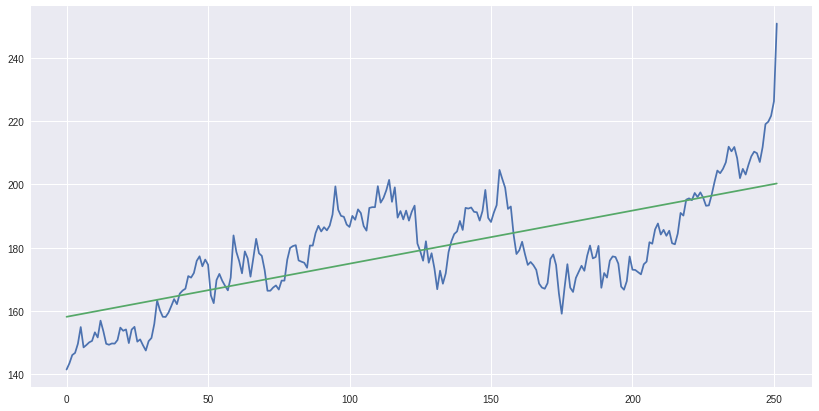

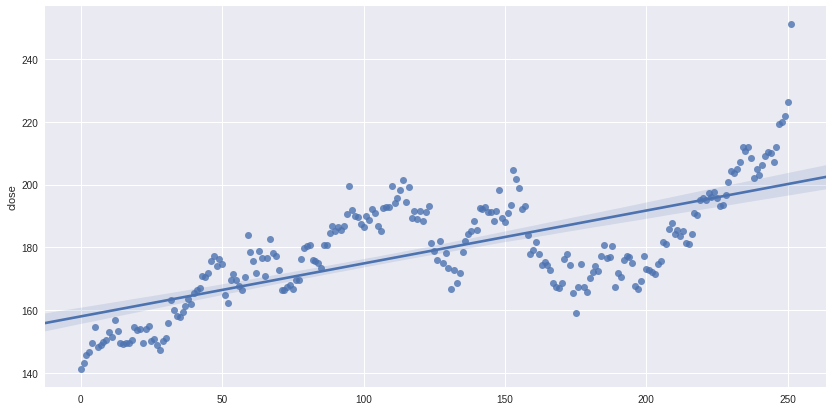

sfun 选股周期内角度=9.644


In [28]:
kl_pd_sfun = kl_pd_manger.get_pick_stock_kl_pd('usBIDU')
print('sfun 选股周期内角度={:.3f}'.format(ABuRegUtil.calc_regress_deg(kl_pd_sfun.close)))

In [8]:
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop, AbuFactorBuyBreak
from abupy import abu, EMarketTargetType, AbuMetricsBase, ABuSymbolPd, tl, get_price, ABuMarketDrawing
from abupy import AbuFuturesCn, AbuFuturesGB, ABuProgress

In [22]:
sd_line = lambda sym: tl.AbuTLine(
    ABuSymbolPd.make_kl_df(sym, start='2014-06-27', end='2015-07-27').close, '').show_shift_distance(
    step_x=1.2, show_log=False)

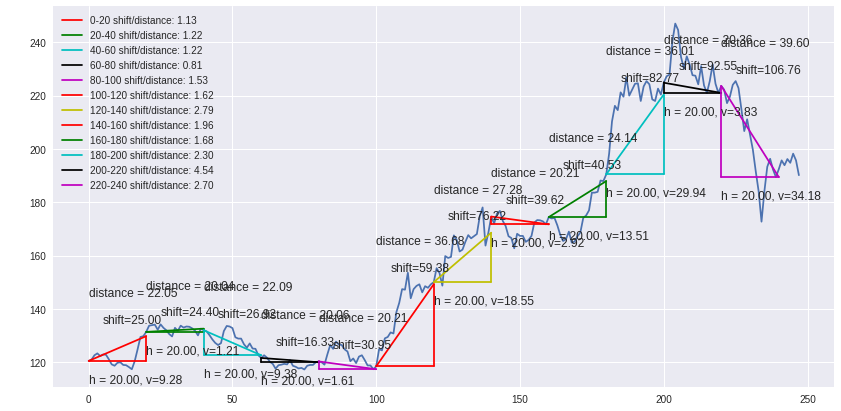

[(20,
  9.2751020408163072,
  22.046031794124648,
  25.002448979591833,
  1.1341020104241655),
 (20,
  1.2097959183673481,
  20.03655674421377,
  24.397551020408258,
  1.2176518816015567),
 (20,
  9.3759183673469408,
  22.08863611070529,
  26.917959183673418,
  1.2186338282166542),
 (20,
  1.6130612244897833,
  20.064943720677427,
  16.332244897959228,
  0.8139691356885512),
 (20,
  2.9236734693877509,
  20.212567045172708,
  30.950612244897997,
  1.5312558852978457),
 (20,
  30.748979591836729,
  36.681054318805934,
  59.380816326530606,
  1.6188415908232707),
 (20,
  18.550204081632614,
  27.278381027293744,
  76.21714285714285,
  2.7940493528880173),
 (20,
  2.9236734693877224,
  20.212567045172705,
  39.62081632653059,
  1.9602070453487048),
 (20,
  13.50938775510204,
  24.135110472456947,
  40.52816326530606,
  1.6792201266928906),
 (20,
  29.942448979591802,
  36.0076415625275,
  82.77020408163281,
  2.29868440391748),
 (20,
  3.8310204081632833,
  20.363612581459204,
  92.549387

In [29]:
sd_line('hk02318')

In [23]:
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop, AbuFactorBuyBreak
from abupy import abu, ABuFileUtil, ABuGridHelper, GridSearch, AbuBlockProgress, ABuProgress,AbuDownUpTrend
import ipywidgets

stop_win_range = np.arange(2.0, 2.5, 0.5)
stop_loss_range = np.arange(0.5, 1, 0.5)

sell_atr_nstop_factor_grid = {
              'class': [AbuFactorAtrNStop],
              'stop_loss_n'   : stop_loss_range,
              'stop_win_n'   : stop_win_range
         }

print('AbuFactorAtrNStop止盈参数stop_win_n设置范围:{}'.format(stop_win_range))
print('AbuFactorAtrNStop止损参数stop_loss_n设置范围:{}'.format(stop_loss_range))

AbuFactorAtrNStop止盈参数stop_win_n设置范围:[ 2.]
AbuFactorAtrNStop止损参数stop_loss_n设置范围:[ 0.5]


In [24]:
close_atr_range = np.arange(1.0, 1.5, 0.5)
pre_atr_range = np.arange(1.0, 1.5, 0.5)

sell_atr_pre_factor_grid = {
              'class': [AbuFactorPreAtrNStop],
              'pre_atr_n' : pre_atr_range
         }

sell_atr_close_factor_grid = {
              'class': [AbuFactorCloseAtrNStop],
              'close_atr_n' : close_atr_range
         }

print('暴跌保护止损参数pre_atr_n设置范围:{}'.format(pre_atr_range))
print('盈利保护止盈参数close_atr_n设置范围:{}'.format(close_atr_range))

暴跌保护止损参数pre_atr_n设置范围:[ 1.]
盈利保护止盈参数close_atr_n设置范围:[ 1.]


In [25]:
sell_factors_product = ABuGridHelper.gen_factor_grid(
    ABuGridHelper.K_GEN_FACTOR_PARAMS_SELL,
    [sell_atr_nstop_factor_grid, sell_atr_pre_factor_grid, sell_atr_close_factor_grid], need_empty_sell=True)

print('卖出因子参数共有{}种组合方式'.format(len(sell_factors_product)))
print('卖出因子组合0: 形式为{}'.format(sell_factors_product[0]))

卖出因子参数共有5种组合方式
卖出因子组合0: 形式为[{'stop_loss_n': 0.5, 'class': <class 'abupy.FactorSellBu.ABuFactorAtrNStop.AbuFactorAtrNStop'>, 'stop_win_n': 2.0}, {'class': <class 'abupy.FactorSellBu.ABuFactorPreAtrNStop.AbuFactorPreAtrNStop'>, 'pre_atr_n': 1.0}, {'close_atr_n': 1.0, 'class': <class 'abupy.FactorSellBu.ABuFactorCloseAtrNStop.AbuFactorCloseAtrNStop'>}]


In [26]:
buy_bk_factor_grid1 = {
    'class': [AbuFactorBuyBreak],
    'xd': [42]
}

buy_bk_factor_grid2 = {
    'class': [AbuFactorBuyBreak],
    'xd': [60]
}

buy_factors_product = ABuGridHelper.gen_factor_grid(
    ABuGridHelper.K_GEN_FACTOR_PARAMS_BUY, [buy_bk_factor_grid1, buy_bk_factor_grid2])

print('买入因子参数共有{}种组合方式'.format(len(buy_factors_product)))
print('买入因子组合形式为{}'.format(buy_factors_product))

买入因子参数共有3种组合方式
买入因子组合形式为[[{'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 42}, {'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 60}], [{'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 42}], [{'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 60}]]


In [28]:
from abupy import abu, ABuFileUtil, ABuGridHelper, GridSearch, AbuBlockProgress, ABuProgress
read_cash=1000000
grid_search = GridSearch(read_cash, choice_symbols=stock_pick.choice_symbols,
                         buy_factors_product=buy_factors_product,
                         sell_factors_product=sell_factors_product)

In [29]:
scores = None
score_tuple_array = None

def run_grid_search():
    global scores, score_tuple_array
    # 运行GridSearch n_jobs=-1启动cpu个数的进程数
    scores, score_tuple_array = grid_search.fit(n_jobs=-1)
    # 运行完成输出的score_tuple_array可以使用dump_pickle保存在本地，以方便之后使用
    ABuFileUtil.dump_pickle(score_tuple_array, '../gen/score_tuple_array')
        
def select(select):
    if select == 'run gird search':
        run_grid_search()
    else: # load score cache
        load_score_cache()

_ = ipywidgets.interact_manual(select, select=['run gird search', 'load score cache'])

买入后卖出的交易数量:7
买入后尚未卖出的交易数量:0
胜率:57.1429%
平均获利期望:14.0183%
平均亏损期望:-4.5209%
盈亏比:4.0180
策略收益: 7.1938%
基准收益: 15.0841%
策略年化收益: 3.5969%
基准年化收益: 7.5420%
策略买入成交比例:100.0000%
策略资金利用率比例:7.8789%
策略共执行504个交易日


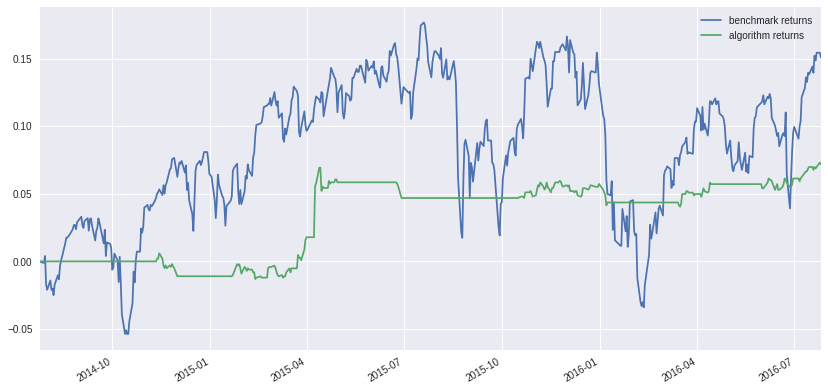

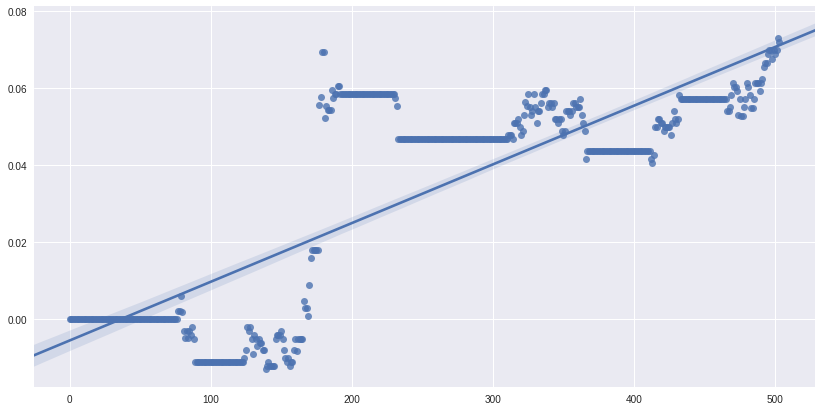

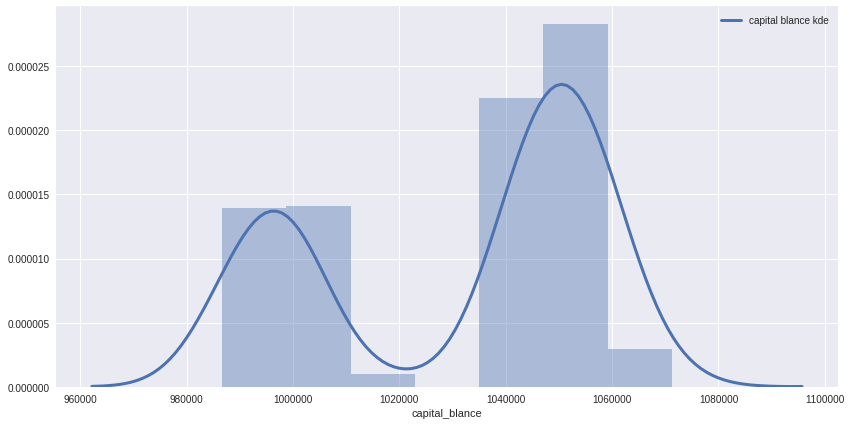

alpha阿尔法:0.0333
beta贝塔:0.0269
Information信息比率:-0.0183
策略Sharpe夏普比率: 0.9039
基准Sharpe夏普比率: 0.5012
策略波动率Volatility: 0.0394
基准波动率Volatility: 0.1689


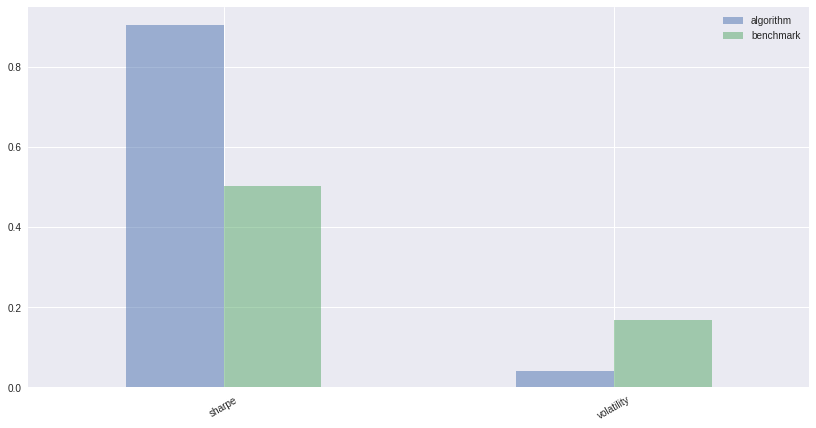

In [30]:
from abupy import AbuMetricsBase
best_score_tuple_grid = grid_search.best_score_tuple_grid
AbuMetricsBase.show_general(best_score_tuple_grid.orders_pd, best_score_tuple_grid.action_pd,
                                        best_score_tuple_grid.capital, best_score_tuple_grid.benchmark)

In [15]:
grid_search.best_score_tuple_grid

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4 entries, 2015-06-04 to 2016-03-15
Data columns (total 19 columns):
buy_date            4 non-null int64
buy_price           4 non-null float64
buy_cnt             4 non-null float64
buy_factor          4 non-null object
symbol              4 non-null object
buy_pos             4 non-null object
buy_type_str        4 non-null object
expect_direction    4 non-null float64
sell_type_extra     4 non-null object
sell_date           4 non-null int64
sell_price          4 non-null float64
sell_type           4 non-null object
ml_features         0 non-null object
key                 4 non-null int64
profit              4 non-null float64
result              4 non-null int64
profit_cg           4 non-null float64
profit_cg_hunder    4 non-null float64
keep_days           4 non-null int64
dtypes: float64(7), int64(5), object(7)
memory usage: 640.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total

orders_pd:None
action_pd:None
capital:capital_pd:
None
commission_pd:
None
benchmark:benchmark is us.IXIC, n_folds = 2
buy_factors:[{'class': <class 'abupy.FactorBuyBu.ABuFactorBuyTrend.AbuDownUpTrend'>}]
sell_factors:[{'stop_loss_n': 0.5, 'class': <class 'abupy.FactorSellBu.ABuFactorAtrNStop.AbuFactorAtrNStop'>, 'stop_win_n': 2.0}, {'class': <class 'abupy.FactorSellBu.ABuFactorPreAtrNStop.AbuFactorPreAtrNStop'>, 'pre_atr_n': 1.0}, {'close_atr_n': 1.0, 'class': <class 'abupy.FactorSellBu.ABuFactorCloseAtrNStop.AbuFactorCloseAtrNStop'>}]
stock_picks:None